In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
import numpy as np

launch.json used to generate epoch-wise pkls

In [2]:
# {
#     "version": "0.2.0",
#     "configurations": [
#    	 {
#    		 "name": "Run with argument",
#    		 "type": "python",
#    		 "request": "launch",
#    		 "program": "${file}",
#    		 "console": "integratedTerminal",
#    		 "cwd": "${workspaceFolder}/tools",
#    		 "env": {"CUDA_VISIBLE_DEVICES": "1"},
#    		 "args": ["--cfg_file" ,
#            		 "cfgs/kitti_models/pv_rcnn_ssl_60.yaml",
#            		 "--split",
#            		 "train_0.01_1",
#            		 "--batch_size",
#            		 "8",
#            		 "--ckpt_save_interval",
#            		 "20",
#            		 "--repeat",
#            		 "5",
#            		 "--fix_random_seed",
#            		 "--extra_tag",
#            		 "tsne_3diou_secndstage_ckpt60_snapshot_new_ulbloader",
#            		 "--dbinfos",
#            		 "kitti_dbinfos_train_0.01_1_37.pkl",
#                  "--epochs", // for repeat 5, bsz 8: to cover 3769 ulb frames needs ~21 epochs
#                  "100",
#                  "--ckpt",
#                  "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/ckpts_3diou_split_1_1_0fbd0d1/ckpt/checkpoint_epoch_60.pth",
#                 "--set",
#                  "MODEL.STORE_SCORES_IN_PKL",
#                 "True"
#    		 ],
#    	 }
#     ]
# }


Script to read epoch wise pkls, combine and store as snapshot_pl_data


In [3]:
import os
import pickle
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/mnt/data/adat01/adv_OpenPCDet/tools/cfgs/kitti_models/pv_rcnn_ssl_60/exp1_batch_dict_new_4f0683d/"
# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
snapshot_pl_data = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in snapshot_pl_data:
            snapshot_pl_data[key] = []
        snapshot_pl_data[key].extend(value)



In [4]:
snapshot_pl_data.keys()

dict_keys(['iou_roi_pl', 'iou_roi_gt', 'pred_scores', 'teacher_pred_scores', 'weights', 'roi_scores', 'pcv_scores', 'num_points_in_roi', 'class_labels', 'iteration', 'obj_scores', 'gt_boxes', 'assigned_gt_inds', 'assigned_iou_class', 'iou_values', 'pl_conf_scores', 'pl_sem_scores', 'shared_features', 'frame_id', 'shared_features_gt', 'labeled_mask', 'unlabeled_mask', 'pl_boxes', 'ori_gt_boxes', 'iou_assigned_label'])

In [5]:
print(np.array(snapshot_pl_data['labeled_mask']).sum())
print(np.array(snapshot_pl_data['unlabeled_mask']).sum())
print(len(snapshot_pl_data['frame_id']))

0
343
343


In [6]:
frames =  np.array(snapshot_pl_data['frame_id'])
np.unique(frames).shape

(319,)

In [7]:
pl_boxes = np.concatenate(snapshot_pl_data['pl_boxes']) #6091,8
gt_boxes = np.concatenate(snapshot_pl_data['ori_gt_boxes'])  #9523,8

print(pl_boxes.shape, gt_boxes.shape)


(1328, 8) (1560, 8)


In [8]:
pl_classes = pl_boxes[:,-1]
class_counts = {class_id: np.sum(pl_classes == class_id) for class_id in np.unique(pl_classes)}
for class_id, count in class_counts.items():
    print(f"Count of PL Class {int(class_id)}: {count}")
gt_classes = gt_boxes[:,-1]
class_counts = {class_id: np.sum(gt_classes == class_id) for class_id in np.unique(pl_classes)}
for class_id, count in class_counts.items():
    print(f"Count of GT Class {int(class_id)}: {count}")

Count of PL Class 0: 1056
Count of PL Class 1: 210
Count of PL Class 2: 62
Count of GT Class 0: 1272
Count of GT Class 1: 217
Count of GT Class 2: 71


In [9]:
snapshot_pl_data['ori_gt_boxes'][0]

tensor([[42.6240, 15.2097, -1.2692,  4.1800,  1.7600,  1.5600,  3.1424,  0.0000],
        [61.5240, 17.4335, -1.0032,  4.8900,  1.8300,  1.9500,  3.1424,  0.0000]])

In [10]:
snapshot_pl_data['pl_boxes'][0]

tensor([[42.7019, 15.2040, -1.1673,  4.2307,  1.6918,  1.4174,  3.1277,  0.0000]])

In [11]:
for i in range(len(snapshot_pl_data['iou_assigned_label'])):
    snapshot_pl_data['iou_assigned_label'][i] = snapshot_pl_data['iou_assigned_label'][i].cpu()

iou_assigned_label = np.concatenate(snapshot_pl_data['iou_assigned_label'])
iou_assigned_label.shape

(1328,)

In [12]:
iou_assigned_label[:10]

array([ 0,  0,  0, -1,  0, -1,  0,  0,  2,  0])

In [13]:
pl_labels = np.concatenate(snapshot_pl_data['pl_boxes'])
pl_labels = pl_labels[:, -1]
pl_labels.shape

(1328,)

In [14]:
sh_gt_array = np.concatenate(snapshot_pl_data['shared_features_gt'])
sh_gt_array.shape

(1328, 256)

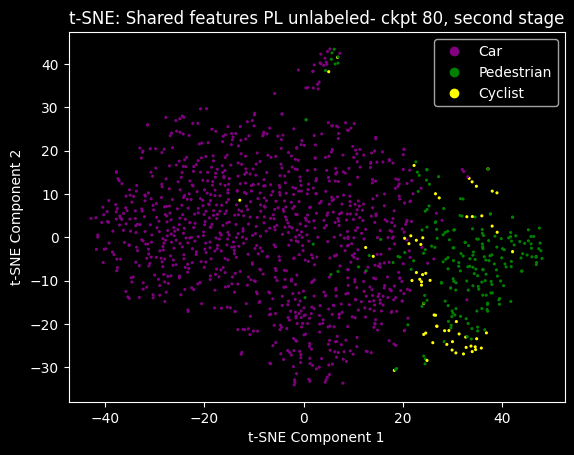

In [15]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_labels = iou_assigned_label

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create custom colormap
colors = ['purple', 'green', 'yellow']
cmap = ListedColormap(colors)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

# Add legend
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = "t-SNE: Shared features PL unlabeled- ckpt 80, second stage"
plt.title(title)

plt.show()


In [16]:
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[pl_labels[i]] for i in range(len(pl_labels))]


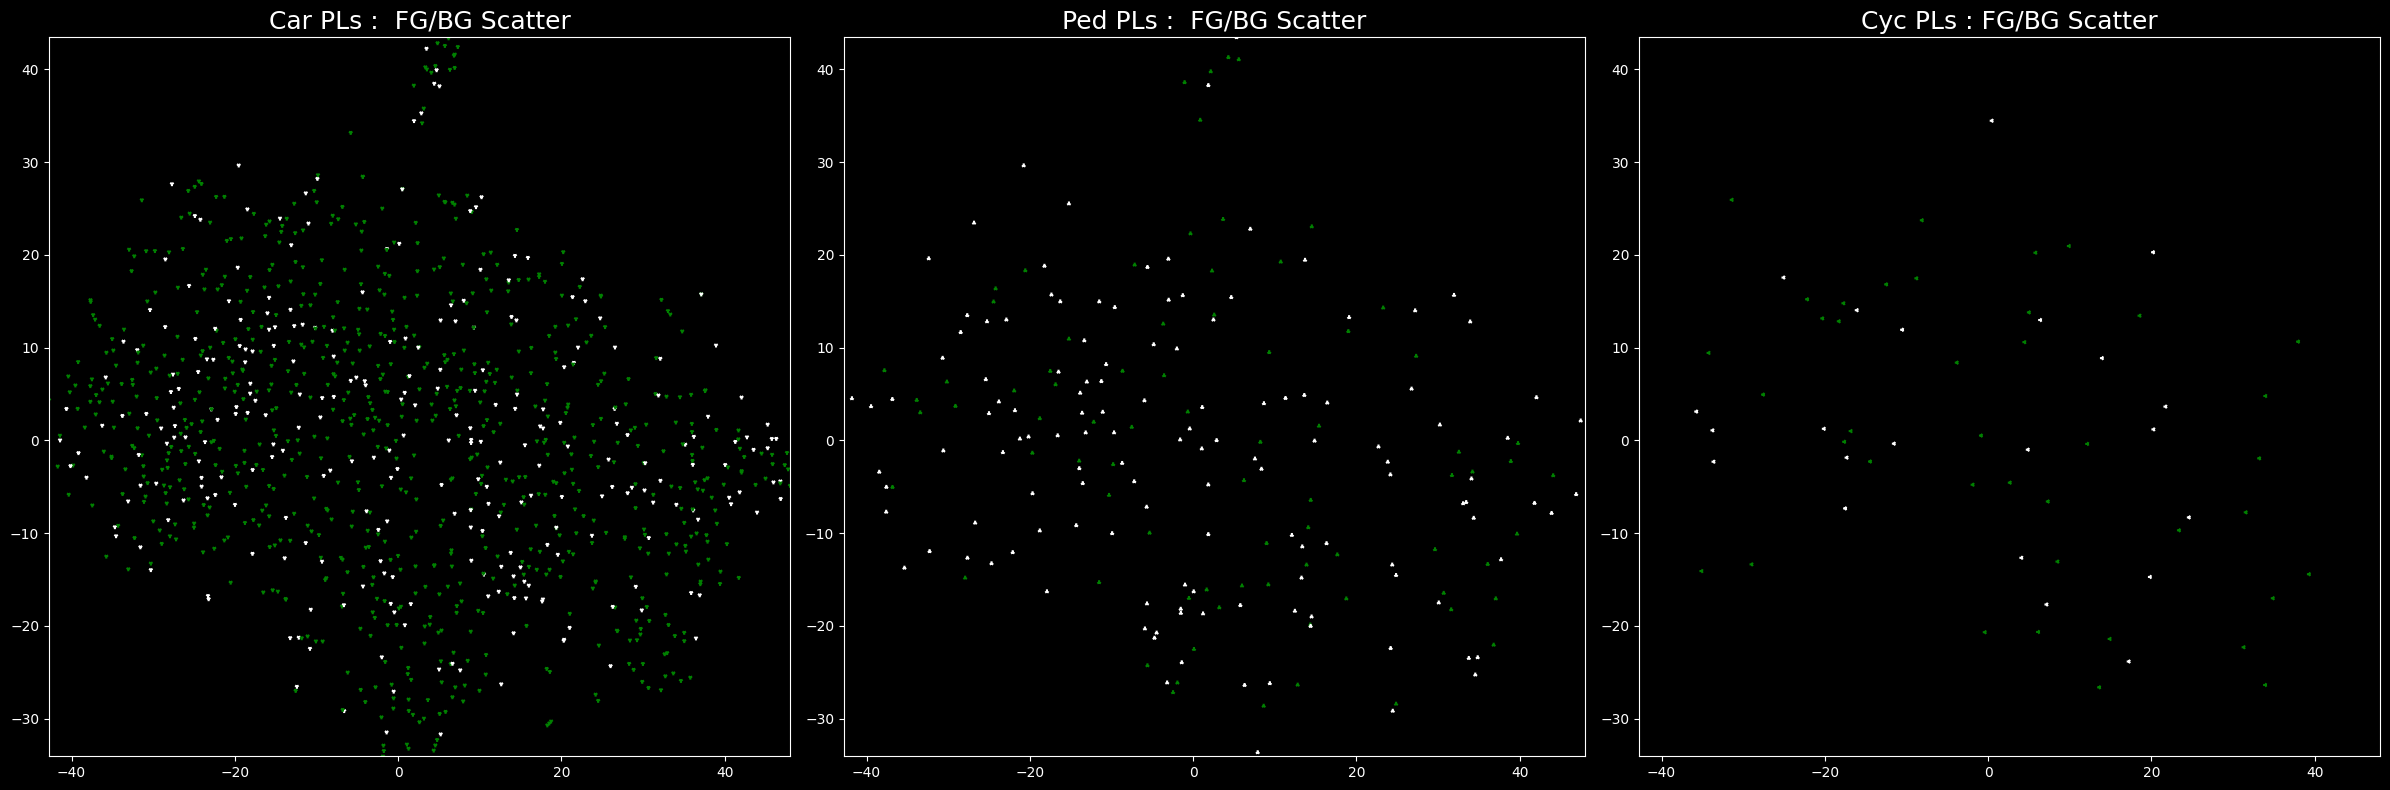

In [17]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('dark_background')

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
conf_scores = iou_assigned_label
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[y[i]] for i in range(len(y))]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(y, conf_scores)]
colors = ['white' if result == -1 else ('red' if result == 0 else 'green') for result in comparison_result]

# gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
# tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

import numpy as np

# Get the indices that would sort y in ascending order
sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]
sorted_assigned_labels = [conf_scores[i] for i in sorted_indices]
idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # Create a figure with 3 subplots side by side
for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(False)
# Plot the first scatter plot in the first subplot
axs[0].scatter(x_tsne[:idx_1_first, 0], x_tsne[:idx_1_first, 1], marker='1', color=sorted_colors[:idx_1_first], s=10)
axs[0].set_title('Car PLs :  FG/BG Scatter',fontsize = 18)

# Plot the second scatter plot in the second subplot
axs[1].scatter(x_tsne[idx_1_first:idx_1_last, 0], x_tsne[idx_1_first:idx_1_last, 1], marker='2', color=sorted_colors[idx_1_first:idx_1_last], s=10)
axs[1].set_title('Ped PLs :  FG/BG Scatter',fontsize = 18)

# Plot the third scatter plot in the third subplot
axs[2].scatter(x_tsne[idx_1_last:, 0], x_tsne[idx_1_last:, 1], marker='3', color=sorted_colors[idx_1_last:], s=10)
axs[2].set_title('Cyc PLs : FG/BG Scatter', fontsize = 18)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [18]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_precision_recall(sorted_y, sorted_assigned_labels, class_id):
    true_positives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == 1))
    false_positives = np.sum((sorted_y != class_id) & (sorted_assigned_labels == 0))
    false_negatives = np.sum((sorted_y == class_id) & (sorted_assigned_labels == -1))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall

comparison_result = np.array(comparison_result)
precision_car, recall_car = calculate_precision_recall(sorted_y, comparison_result, class_id=0)
precision_pedestrian, recall_pedestrian = calculate_precision_recall(sorted_y, comparison_result, class_id=1)
precision_cyclist, recall_cyclist = calculate_precision_recall(sorted_y, comparison_result, class_id=2)

print("Precision and Recall for Car class:")
print("Precision:", precision_car)
print("Recall:", recall_car)

print("\nPrecision and Recall for Pedestrian class:")
print("Precision:", precision_pedestrian)
print("Recall:", recall_pedestrian)

print("\nPrecision and Recall for Cyclist class:")
print("Precision:", precision_cyclist)
print("Recall:", recall_cyclist)


# plt.figure(figsize=(8, 6))
# plt.plot(recall_car, precision_car, marker='o', linestyle='-', label='Car')
# plt.plot(recall_pedestrian, precision_pedestrian, marker='o', linestyle='-', label='Pedestrian')
# plt.plot(recall_cyclist, precision_cyclist, marker='o', linestyle='-', label='Cyclist')

# plt.xlabel('Recall')
# plt.ylabel('Precision')
# plt.title('Precision-Recall Curve')
# plt.legend()
# plt.grid(True)
# plt.show()


Precision and Recall for Car class:
Precision: 1.0
Recall: 0.6714015151515151

Precision and Recall for Pedestrian class:
Precision: 1.0
Recall: 0.6952380952380952

Precision and Recall for Cyclist class:
Precision: 1.0
Recall: 0.6290322580645161


In [19]:
import os
import pickle
import torch
# Directory containing the pickle files
pickle_dir = "/mnt/data/adat01/adv_OpenPCDet/output/cfgs/kitti_models/pv_rcnn_ssl_60/exp1_batch_dict_new_30_4f0683d"
# List all pickle files in the directory
pickle_files = [file for file in os.listdir(pickle_dir) if file.endswith(".pkl")]

# Initialize an empty dictionary to store aggregated data
snapshot_pl_data_20 = {}

# Iterate over each pickle file
for file in pickle_files:
    # Load the pickle file
    with open(os.path.join(pickle_dir, file), "rb") as f:
        data = pickle.load(f)
    # Combine the data from the current file with the aggregated data
    for key, value in data.items():
        if key not in snapshot_pl_data_20:
            snapshot_pl_data_20[key] = []
        snapshot_pl_data_20[key].extend(value)



In [20]:
sh_gt_array = np.concatenate(snapshot_pl_data_20['shared_features_gt'])
sh_gt_array.shape
pl_labels = np.concatenate(snapshot_pl_data_20['pl_boxes'])
pl_labels = pl_labels[:, -1]
pl_labels.shape
for i in range(len(snapshot_pl_data_20['iou_assigned_label'])):
    snapshot_pl_data_20['iou_assigned_label'][i] = snapshot_pl_data_20['iou_assigned_label'][i].cpu()

iou_assigned_label = np.concatenate(snapshot_pl_data_20['iou_assigned_label'])
iou_assigned_label.shape
pl_boxes = np.concatenate(snapshot_pl_data_20['pl_boxes']) #6091,8
gt_boxes = np.concatenate(snapshot_pl_data_20['ori_gt_boxes'])  #9523,8
frames =  np.array(snapshot_pl_data_20['frame_id'])
np.unique(frames).shape
print(pl_boxes.shape, gt_boxes.shape)
print(np.unique(frames).shape)


(14094, 8) (16516, 8)
(2213,)


In [21]:
snapshot_pl_data_20.keys()
iou_assigned_label = np.concatenate(snapshot_pl_data_20['iou_assigned_label'])
iou_assigned_label.shape

(14094,)

In [22]:
len(snapshot_pl_data_20['iou_values'])
iou_values = np.concatenate((snapshot_pl_data_20['iou_values']))
iou_values.shape


(14094,)

In [23]:
(iou_assigned_label > -1).sum()

9319

In [24]:
pl_labels

array([1., 0., 0., ..., 0., 0., 0.], dtype=float32)

In [25]:
iou_values[pl_labels ==0]

array([0.76553416, 0.8526509 , 0.781896  , ..., 0.68965095, 0.77190953,
       0.        ], dtype=float32)

In [26]:
PL_all_precision  = (iou_assigned_label > -1).sum() / iou_assigned_label.shape[0]
PL_car_precision = ((iou_assigned_label==0).astype(int) * (pl_labels.astype(int)==0)).sum() / (pl_labels==0).sum()
PL_ped_precision = ((iou_assigned_label==1).astype(int) * (pl_labels.astype(int)==1)).sum() / (pl_labels==1).sum()
PL_cyc_precision =((iou_assigned_label==2).astype(int) * (pl_labels.astype(int)==2)).sum() / (pl_labels==2).sum()

print("Precision FG/BG all PLs:",PL_all_precision )
print("Precision FG/BG for Car PLs:", PL_car_precision)
print("Precision FG/BG for Pedestrian PLs:", PL_ped_precision)
print("Precision FG/BG for for Cyclist PLs:", PL_cyc_precision)



Precision FG/BG all PLs: 0.6612033489428125
Precision FG/BG for Car PLs: 0.7163027273524512
Precision FG/BG for Pedestrian PLs: 0.3583535108958838
Precision FG/BG for for Cyclist PLs: 0.6565495207667732


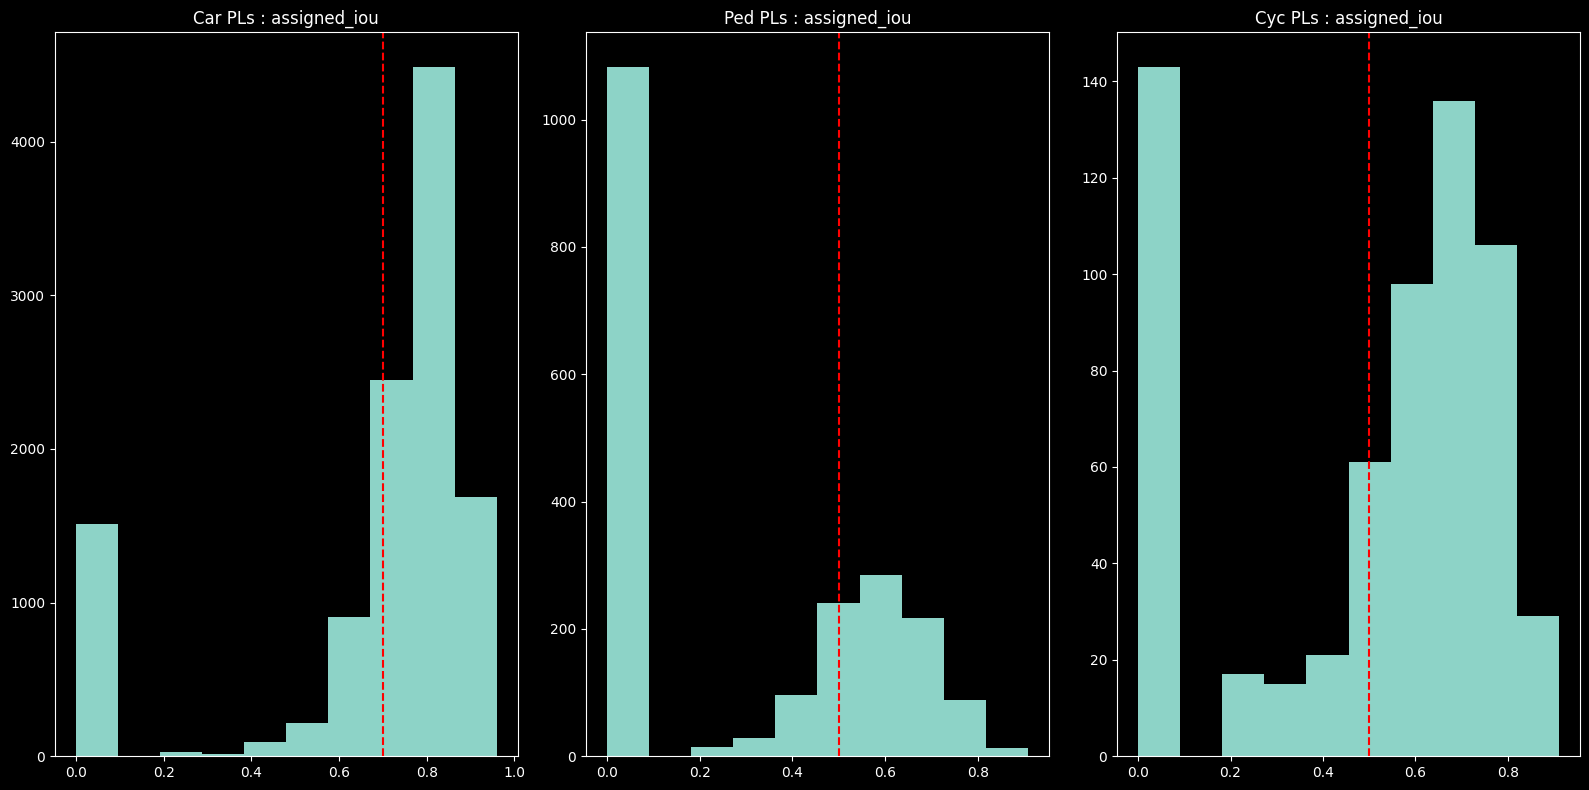

In [27]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
fig, axs = plt.subplots(1, 3, figsize=(16, 8))  # Create a figure with 3 subplots side by side
for ax in axs:
    ax.grid(False)
# Plot the first scatter plot in the first subplot
axs[0].hist(iou_values[pl_labels ==0])
axs[0].set_title('Car PLs : assigned_iou',fontsize = 12)
axs[0].axvline(x=0.7, color='red', linestyle='--')
# Plot the second scatter plot in the second subplot
axs[1].hist(iou_values[pl_labels ==1])
axs[1].set_title('Ped PLs : assigned_iou',fontsize = 12)
axs[1].axvline(x=0.5, color='red', linestyle='--')
# Plot the third scatter plot in the third subplot
axs[2].hist(iou_values[pl_labels ==2])
axs[2].set_title('Cyc PLs : assigned_iou', fontsize = 12)
axs[2].axvline(x=0.5, color='red', linestyle='--')
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

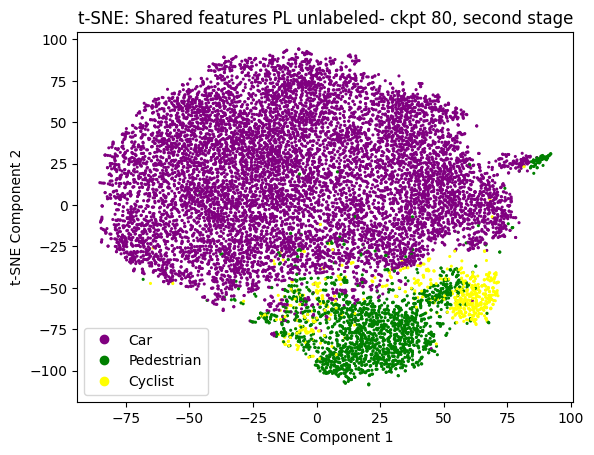

In [36]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_labels = iou_assigned_label

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

# Create custom colormap
colors = ['purple', 'green', 'yellow']
cmap = ListedColormap(colors)

# Create a scatter plot with colored points based on labels
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

# Add legend
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = "t-SNE: Shared features PL unlabeled- ckpt 80, second stage"
plt.title(title)

plt.show()


In [29]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x = sh_gt_array
y = pl_labels.astype(int)
x_normalized = scaler.fit_transform(x)
iou_asgns = iou_assigned_label
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[y[i]] for i in range(len(y))]
# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_iou_asgns = iou_asgns[sorted_indices]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(sorted_y, sorted_iou_asgns)]

colors = [(1,0,0,0.9) if result == -1 else ((0,0,0,0) if result == 1 else (0,0,0,0)) for result in comparison_result]
idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1


In [30]:
# Get indices where comparison_result is -1
indices_result_minus_1 = [i for i, result in enumerate(comparison_result) if result == -1]

# Filter arrays based on these indices
filtered_sorted_x_tsne = sorted_x_tsne[indices_result_minus_1]
filtered_sorted_y = sorted_y[indices_result_minus_1]
filtered_sorted_iou_asgn = sorted_iou_asgns[indices_result_minus_1]
filtered_colors = [colors[i] for i in indices_result_minus_1]


In [31]:
idx_0_last = np.where(filtered_sorted_y == 0)[0][-1]
idx_1_first = np.where(filtered_sorted_y == 1)[0][0]
idx_1_last = np.where(filtered_sorted_y == 1)[0][-1]+1

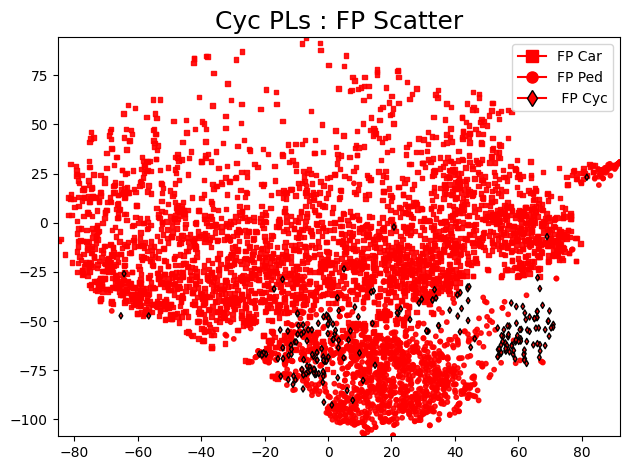

In [32]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('default')

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.scatter(filtered_sorted_x_tsne[:idx_0_last, 0], filtered_sorted_x_tsne[:idx_0_last, 1], marker='s', color=filtered_colors[:idx_0_last], s=10)
plt.scatter(filtered_sorted_x_tsne[idx_1_first:idx_1_last, 0], filtered_sorted_x_tsne[idx_1_first:idx_1_last, 1], marker='o', color=filtered_colors[idx_1_first:idx_1_last], s=10)
plt.scatter(filtered_sorted_x_tsne[idx_1_last:, 0], filtered_sorted_x_tsne[idx_1_last:, 1], marker='d', color=filtered_colors[idx_1_last:], s=10, edgecolors='black')

plt.title('Cyc PLs : FP Scatter', fontsize = 18)
marker_dict = {'FP Car': 's', 'FP Ped': 'o', ' FP Cyc': 'd'}
legend_markers = []
for label,marker in marker_dict.items():
    if marker=='d':
        legend_markers.append((plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8,markeredgecolor = 'black')))
    else:
        legend_markers.append((plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8)))
# legend_markers = [plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8) for label, marker in marker_dict.items()]
plt.legend(handles=legend_markers)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


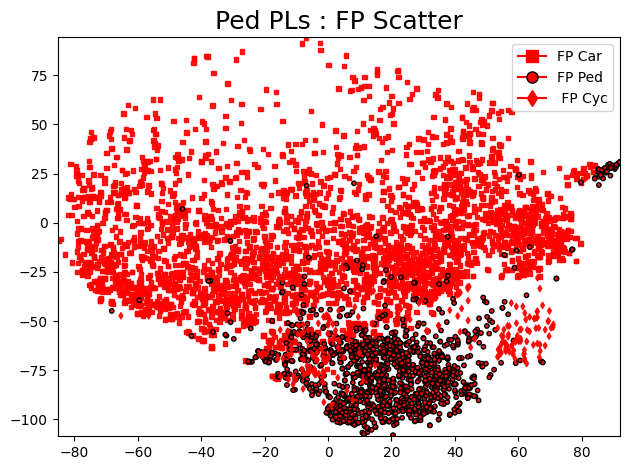

In [33]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('default')

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.scatter(filtered_sorted_x_tsne[:idx_0_last, 0], filtered_sorted_x_tsne[:idx_0_last, 1], marker='s', color=filtered_colors[:idx_0_last], s=10)
plt.scatter(filtered_sorted_x_tsne[idx_1_first:idx_1_last, 0], filtered_sorted_x_tsne[idx_1_first:idx_1_last, 1], marker='o', color=filtered_colors[idx_1_first:idx_1_last], s=10,edgecolors='black')
plt.scatter(filtered_sorted_x_tsne[idx_1_last:, 0], filtered_sorted_x_tsne[idx_1_last:, 1], marker='d', color=filtered_colors[idx_1_last:], s=10)

plt.title('Ped PLs : FP Scatter', fontsize = 18)
marker_dict = {'FP Car': 's', 'FP Ped': 'o', ' FP Cyc': 'd'}
legend_markers = []
for label,marker in marker_dict.items():
    if marker=='o':
        legend_markers.append((plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8,markeredgecolor = 'black')))
    else:
        legend_markers.append((plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8)))
# legend_markers = [plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8) for label, marker in marker_dict.items()]
plt.legend(handles=legend_markers)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


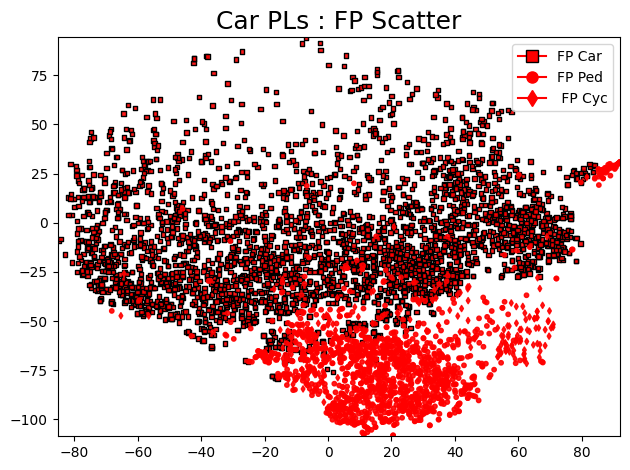

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('default')

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)

plt.scatter(filtered_sorted_x_tsne[:idx_0_last, 0], filtered_sorted_x_tsne[:idx_0_last, 1], marker='s', color=filtered_colors[:idx_0_last], s=10, edgecolors='black')
plt.scatter(filtered_sorted_x_tsne[idx_1_first:idx_1_last, 0], filtered_sorted_x_tsne[idx_1_first:idx_1_last, 1], marker='o', color=filtered_colors[idx_1_first:idx_1_last], s=10)
plt.scatter(filtered_sorted_x_tsne[idx_1_last:, 0], filtered_sorted_x_tsne[idx_1_last:, 1], marker='d', color=filtered_colors[idx_1_last:], s=10)

plt.title('Car PLs : FP Scatter', fontsize = 18)
marker_dict = {'FP Car': 's', 'FP Ped': 'o', ' FP Cyc': 'd'}
legend_markers = []
for label,marker in marker_dict.items():
    if marker=='s':
        legend_markers.append((plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8,markeredgecolor = 'black')))
    else:
        legend_markers.append((plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8)))
# legend_markers = [plt.Line2D([0], [0], marker=marker, color='r', label=label, markersize=8) for label, marker in marker_dict.items()]
plt.legend(handles=legend_markers)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


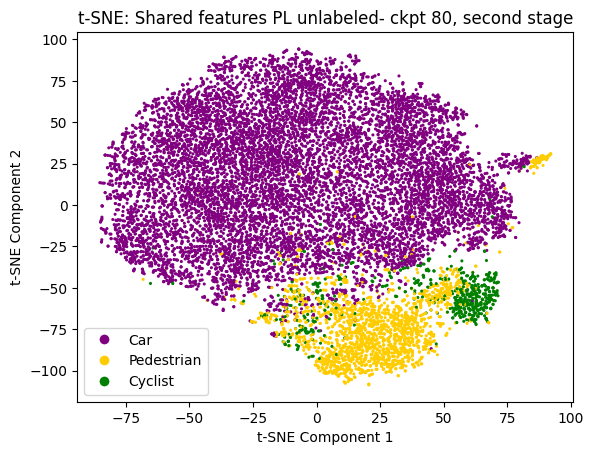

In [63]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from matplotlib.colors import ListedColormap

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
iou_asgns= iou_assigned_label

# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)

darker_yellow = (1, 0.8, 0)  # RGB values for a slightly darker yellow
colors = ['purple', darker_yellow, 'green']
cmap = ListedColormap(colors)
scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

legend_labels = ['Car', 'Pedestrian', 'Cyclist']
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color) for color in colors]
plt.legend(handles=handles, labels=legend_labels)

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
title = "t-SNE: Shared features PL unlabeled- ckpt 80, second stage"
plt.title(title)

plt.show()

In [38]:
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# x = sh_gt_array
# y = pl_labels.astype(int)
# x_normalized = scaler.fit_transform(x)
iou_asgns = iou_assigned_label
# marker_dict = {0:"s",1:"o",2:"d"}
# markers = [marker_dict[y[i]] for i in range(len(y))]
# # Perform t-SNE on normalized features
# tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
# x_tsne = tsne.fit_transform(x_normalized)

sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_iou_asgns = iou_asgns[sorted_indices]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(sorted_y, sorted_iou_asgns)]

colors = [(1,0,0,0.9) if result == -1 else ((0,0,0,0) if result == 1 else (0,0,0,0)) for result in comparison_result]
idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1


In [39]:
# Get indices where comparison_result is -1
indices_result_minus_1 = [i for i, result in enumerate(comparison_result) if result == -1]

# Filter arrays based on these indices
filtered_sorted_x_tsne = sorted_x_tsne[indices_result_minus_1]
filtered_sorted_y = sorted_y[indices_result_minus_1]
filtered_sorted_iou_asgn = sorted_iou_asgns[indices_result_minus_1]
filtered_colors = [colors[i] for i in indices_result_minus_1]


indices_result_plus_1 = [i for i, result in enumerate(comparison_result) if result == 1]

# Filter arrays based on these indices
plus_filtered_sorted_x_tsne = sorted_x_tsne[indices_result_plus_1]
plus_filtered_sorted_y = sorted_y[indices_result_plus_1]
plus_filtered_sorted_iou_asgn = sorted_iou_asgns[indices_result_plus_1]
plus_filtered_colors = [colors[i] for i in indices_result_plus_1]

In [40]:
minus_idx_0_last = np.where(filtered_sorted_y == 0)[0][-1]
minus_idx_1_first = np.where(filtered_sorted_y == 1)[0][0]
minus_idx_1_last = np.where(filtered_sorted_y == 1)[0][-1]+1

plus_idx_0_last = np.where(plus_filtered_sorted_y == 0)[0][-1]
plus_idx_1_first = np.where(plus_filtered_sorted_y == 1)[0][0]
plus_idx_1_last = np.where(plus_filtered_sorted_y == 1)[0][-1]+1

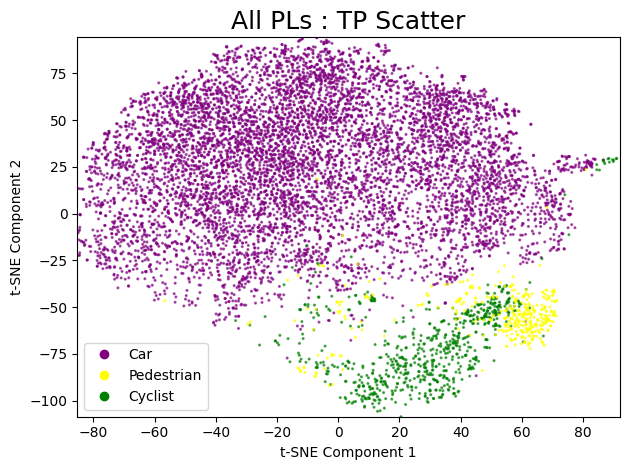

In [41]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('default')

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

colors = ['purple', 'green', 'yellow']
cmap = ListedColormap(colors)


# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
# scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

plt.scatter(plus_filtered_sorted_x_tsne[:, 0], plus_filtered_sorted_x_tsne[:, 1], c = plus_filtered_sorted_y, cmap = cmap, s=1.5, alpha=0.6)
# plt.scatter(x_tsne[plus_idx_1_first:plus_idx_1_last, 0], x_tsne[plus_idx_1_first:plus_idx_1_last, 1],color=colors[plus_idx_1_first:plus_idx_1_last], s=10)
# plt.scatter(x_tsne[plus_idx_1_last:, 0], x_tsne[plus_idx_1_last:, 1], marker='d', color=colors[plus_idx_1_last:], s=10, edgecolors='black')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('All PLs : TP Scatter', fontsize = 18)
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

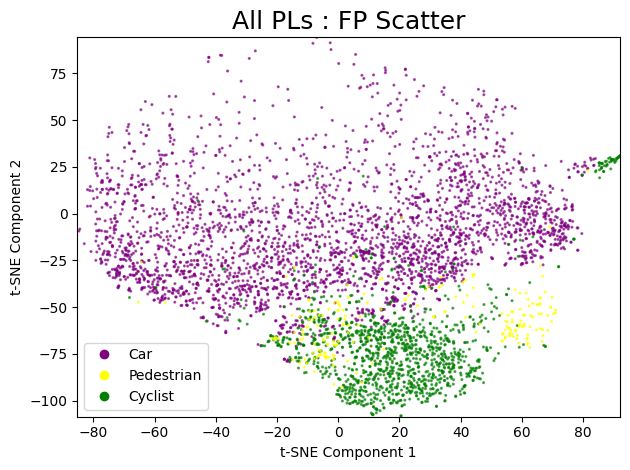

In [42]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
plt.style.use('default')

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

colors = ['purple', 'green', 'yellow']
cmap = ListedColormap(colors)


# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt
plt.xlim(x_min,x_max)
plt.ylim(y_min,y_max)
# scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap=cmap, s=1.5)

plt.scatter(filtered_sorted_x_tsne[:, 0], filtered_sorted_x_tsne[:, 1], c = filtered_sorted_y, cmap = cmap, s=1.5, alpha=0.6)
# plt.scatter(x_tsne[plus_idx_1_first:plus_idx_1_last, 0], x_tsne[plus_idx_1_first:plus_idx_1_last, 1],color=colors[plus_idx_1_first:plus_idx_1_last], s=10)
# plt.scatter(x_tsne[plus_idx_1_last:, 0], x_tsne[plus_idx_1_last:, 1], marker='d', color=colors[plus_idx_1_last:], s=10, edgecolors='black')

plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.title('All PLs : FP Scatter', fontsize = 18)
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
plt.legend(handles=scatter.legend_elements()[0], labels=legend_labels)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

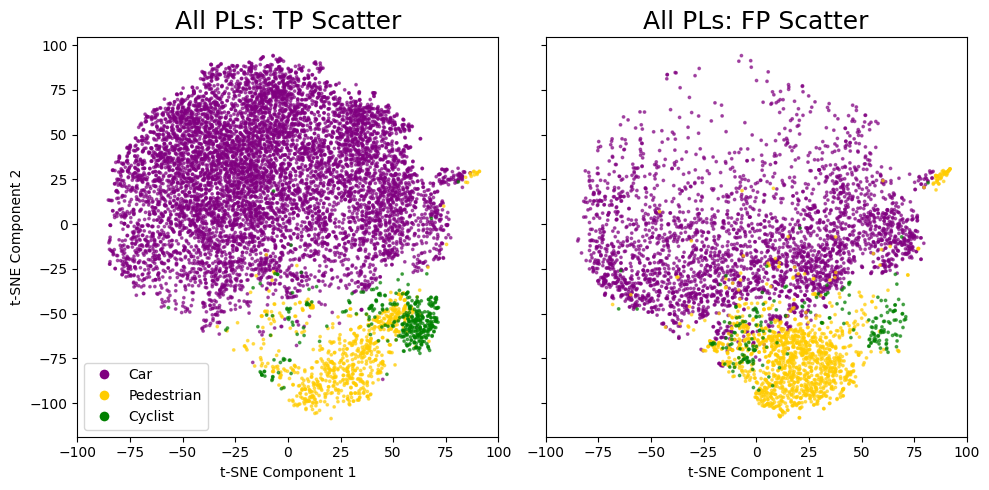

In [64]:
# colors = ['purple', 'yellow', 'green']

darker_yellow = (1, 0.8, 0)  # RGB values for a slightly darker yellow
colors = ['purple', darker_yellow, 'green']
cmap = ListedColormap(colors)


fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10, 5), sharey=True)
ax1.scatter(plus_filtered_sorted_x_tsne[:, 0], plus_filtered_sorted_x_tsne[:, 1], c=plus_filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_title('All PLs: TP Scatter', fontsize=18)
# ax1.legend(handles=scatter.legend_elements()[0], labels=legend_labels)  
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color) for color in colors]
ax1.legend(handles, legend_labels)
# Plot second subplot
ax2.scatter(filtered_sorted_x_tsne[:, 0], filtered_sorted_x_tsne[:, 1], c=filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_title('All PLs: FP Scatter', fontsize=18)
# ax2.legend(handles=scatter.legend_elements(), labels = legend_labels)


for ax in [ax1, ax2]:
    ax.set_xlim(-100, 100)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


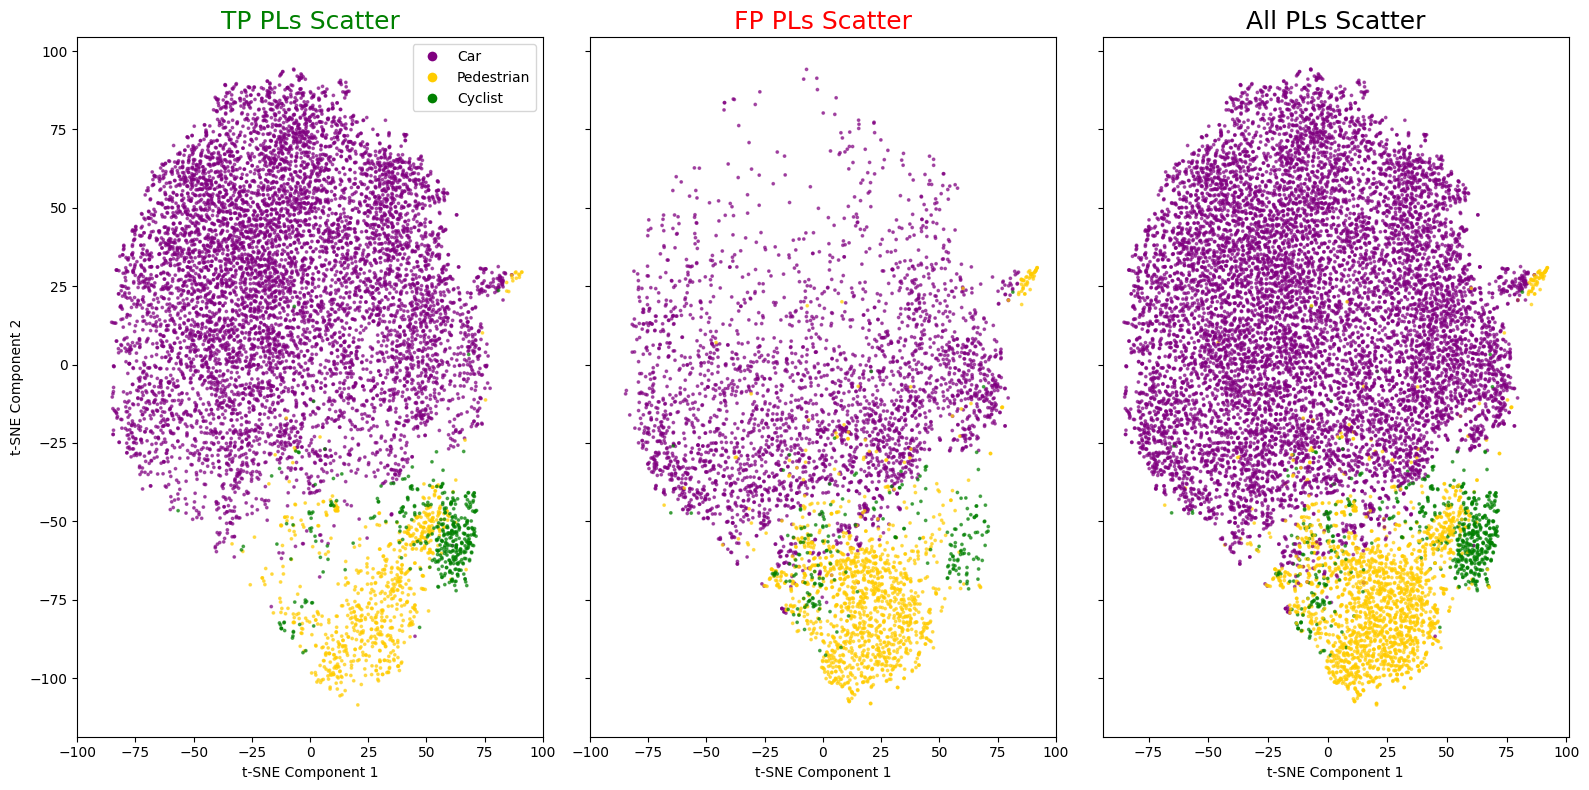

In [66]:
# colors = ['purple', 'yellow', 'green']

darker_yellow = (1, 0.8, 0)  # RGB values for a slightly darker yellow
colors = ['purple', darker_yellow, 'green']
cmap = ListedColormap(colors)


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 8),sharey=True)
ax1.scatter(plus_filtered_sorted_x_tsne[:, 0], plus_filtered_sorted_x_tsne[:, 1], c=plus_filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax1.set_xlabel('t-SNE Component 1')
ax1.set_ylabel('t-SNE Component 2')
ax1.set_title('TP PLs Scatter', fontsize=18, color='green')
# ax1.legend(handles=scatter.legend_elements()[0], labels=legend_labels)  
legend_labels = ['Car', 'Pedestrian', 'Cyclist']
handles = [plt.Line2D([0], [0], marker='o', color='w', markersize=8, markerfacecolor=color) for color in colors]
ax1.legend(handles, legend_labels)
# Plot second subplot
ax2.scatter(filtered_sorted_x_tsne[:, 0], filtered_sorted_x_tsne[:, 1], c=filtered_sorted_y, cmap = cmap, s=3, alpha=0.6)
ax2.set_xlabel('t-SNE Component 1')
ax2.set_title('FP PLs Scatter', fontsize=18, color='red')
# ax2.legend(handles=scatter.legend_elements(), labels = legend_labels)
ax3.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y, cmap = cmap, s=3, alpha=0.6)
ax3.set_xlabel('t-SNE Component 1')
ax3.set_title('All PLs Scatter', fontsize=18, color='black')

for ax in [ax1, ax2]:
    ax.set_xlim(-100, 100)
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


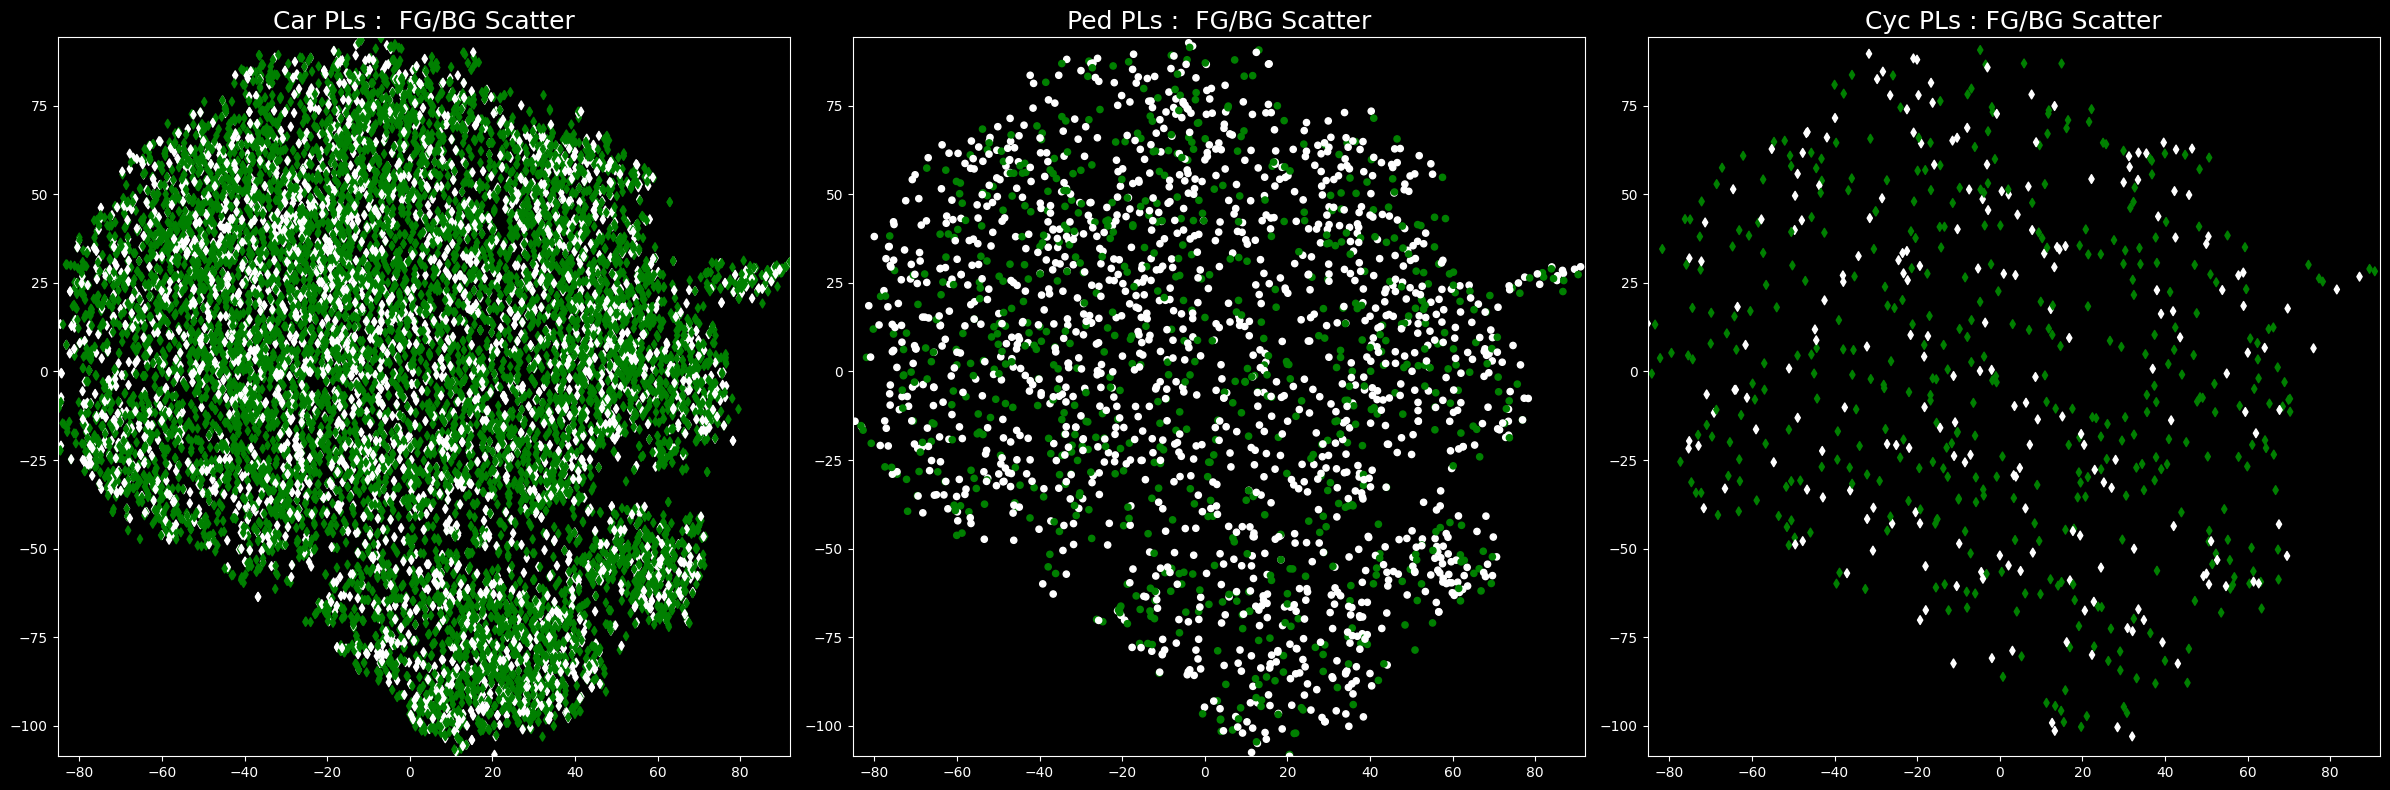

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
# plt.style.use('dark_background')

# Create a sample dataset
x = sh_gt_array
y = pl_labels.astype(int)
conf_scores = iou_assigned_label
marker_dict = {0:"s",1:"o",2:"d"}
markers = [marker_dict[y[i]] for i in range(len(y))]
comparison_result = [-1 if score == -1 else (1 if label == score else 0) for label, score in zip(y, conf_scores)]
colors = ['white' if result == -1 else ('red' if result == 0 else 'white') for result in comparison_result]

# gt_iou_thresh = np.array([0.7, 0.5, 0.5])
# Normalize the features
scaler = StandardScaler()
x_normalized = scaler.fit_transform(x)

# Perform t-SNE on normalized features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', n_iter=1500, random_state=0)
x_tsne = tsne.fit_transform(x_normalized)
# tsne_colors = get_objectness_tp_fp(x_tsne, y, conf_scores, gt_iou_thresh)

import numpy as np

# Get the indices that would sort y in ascending order
sorted_indices = np.argsort(y)
sorted_y = y[sorted_indices]
sorted_x_tsne = x_tsne[sorted_indices]
sorted_colors = [colors[i] for i in sorted_indices]
sorted_assigned_labels = [conf_scores[i] for i in sorted_indices]
idx_0_last = np.where(sorted_y == 0)[0][-1]
idx_1_first = np.where(sorted_y == 1)[0][0]
idx_1_last = np.where(sorted_y == 1)[0][-1]+1

x_min, x_max = min(x_tsne[:, 0]), max(x_tsne[:, 0])
y_min, y_max = min(x_tsne[:, 1]), max(x_tsne[:, 1])

# Plot t-SNE with markers and colors
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(24, 8))  # Create a figure with 3 subplots side by side
for ax in axs:
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.grid(False)
# Plot the first scatter plot in the first subplot
axs[0].scatter(x_tsne[:idx_1_first, 0], x_tsne[:idx_1_first, 1], marker='d', color=sorted_colors[:idx_1_first], s=20)
axs[0].set_title('Car PLs :  FG/BG Scatter',fontsize = 18)

# Plot the second scatter plot in the second subplot
axs[1].scatter(x_tsne[idx_1_first:idx_1_last, 0], x_tsne[idx_1_first:idx_1_last, 1], marker='o', color=sorted_colors[idx_1_first:idx_1_last], s=20)
axs[1].set_title('Ped PLs :  FG/BG Scatter',fontsize = 18)

# Plot the third scatter plot in the third subplot
axs[2].scatter(x_tsne[idx_1_last:, 0], x_tsne[idx_1_last:, 1], marker='d', color=sorted_colors[idx_1_last:], s=20)
axs[2].set_title('Cyc PLs : FG/BG Scatter', fontsize = 18)

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()
